In [19]:
import numpy as np
import pandas as pd
import scanpy as sc # svd, umap, louvain, PAGA, pseudo-time functions
from episcanpy import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Loading data

In [24]:
fdir = '../scATAC-seq_Alan/RC2_Benchmark/HE021320A/outs/filtered_peak_bc_matrix/'
myobj = CreateEpiAnnData(fdir)

Loading matrix file..
Done!
Computing basic QC..
Done!


In [25]:
myobj_raw = myobj #freeze

## QC

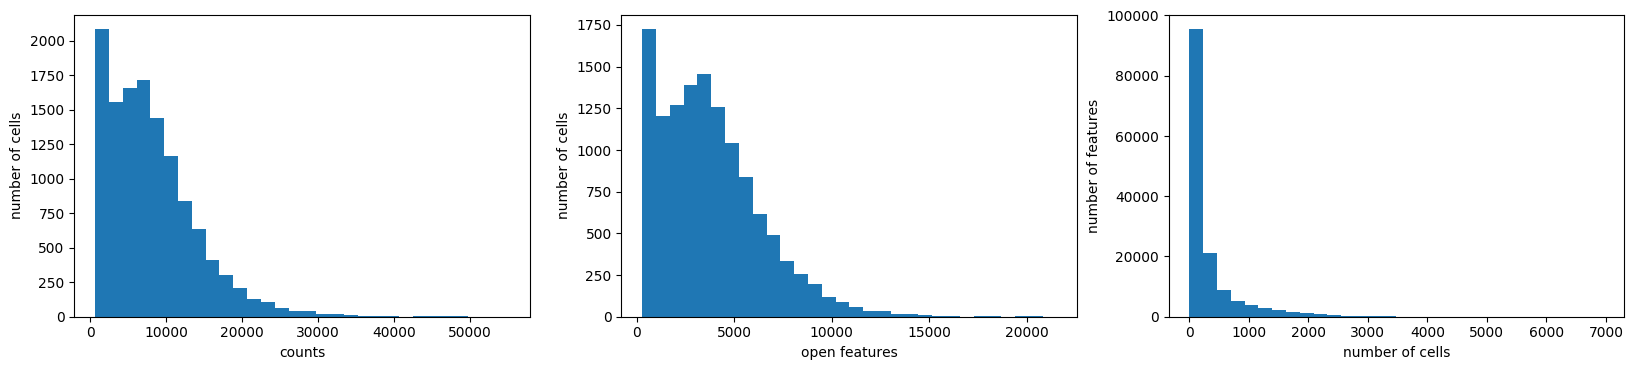

In [26]:
plot_simple_qc(myobj)

In [27]:
myobj = filter_cells_peaks(myobj, min_counts=5000, max_counts=20000, min_cells=10)

In [28]:
myobj = top_n_features(myobj, q = 0.25)

In [29]:
myobj

View of AnnData object with n_obs × n_vars = 7673 × 105255 
    obs: 0, 'nfeatures', 'ncounts'
    var: 0, 'ncells', 'ncounts'

Run TF-IDF

In [30]:
myobj = tf_idf_normalization(myobj)

In [31]:
sc.pp.pca(myobj, zero_center=False) # performs SVD

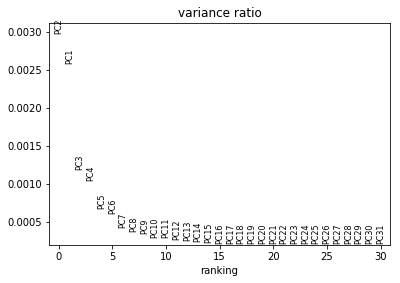

In [32]:
sc.pl.pca_variance_ratio(myobj)

PC 1 is strongly correlated with the number of features. We shouldn't use it.

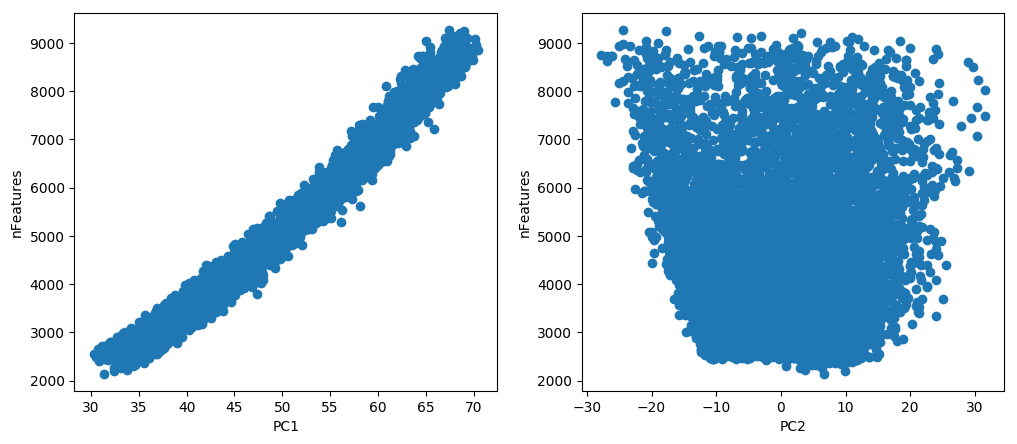

In [33]:
fig, axs = plt.subplots(1,2, figsize=(12,5), dpi=100)
axs[0].scatter(myobj.obsm['X_pca'][:,0], myobj.obs['nfeatures'])
axs[1].scatter(myobj.obsm['X_pca'][:,1], myobj.obs['nfeatures'])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('nFeatures')
axs[1].set_xlabel('PC2')
axs[1].set_ylabel('nFeatures')
plt.show()

In [34]:
myobj.obsm['X_pca'] = np.delete(myobj.obsm['X_pca'], 0, 1)

In [35]:
myobj.obsm['X_pca'].shape

(7673, 49)

In [36]:
t = myobj.obsm['X_pca']
myobj.obsm['X_pca'] = (t - t.mean(axis=0))/t.std(axis=0)

In [37]:
sc.pp.neighbors(myobj, n_neighbors=15, n_pcs=15, metric='cosine')

In [68]:
sc.tl.umap(myobj, min_dist=0.4)

In [69]:
sc.tl.leiden(myobj, resolution=0.4)

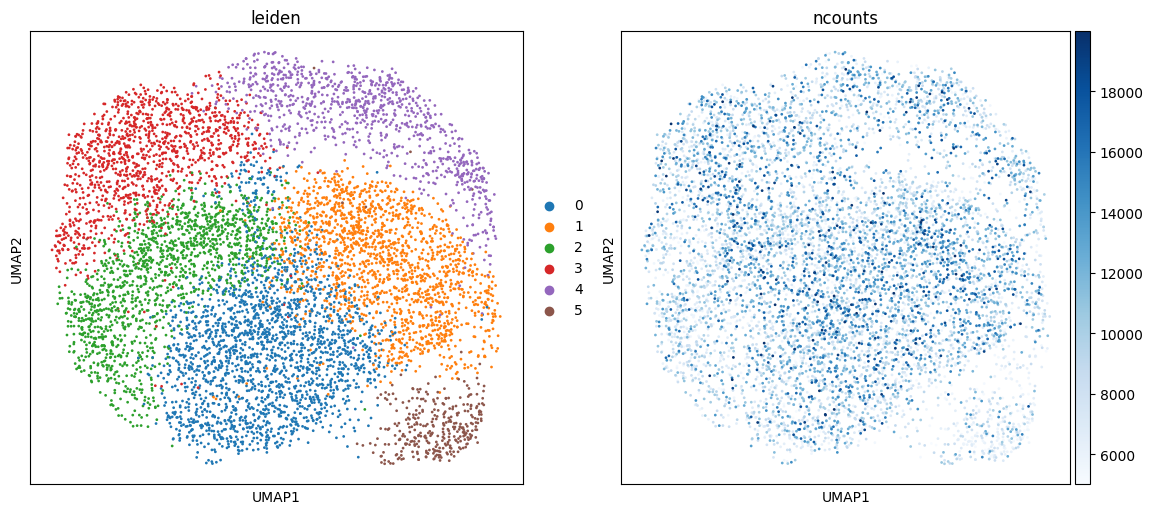

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(14,6), dpi=100)
sc.pl.umap(myobj, show=False, ax=axs[0], color='leiden')
sc.pl.umap(myobj, show=False, ax=axs[1], color='ncounts', color_map='Blues')
plt.show()

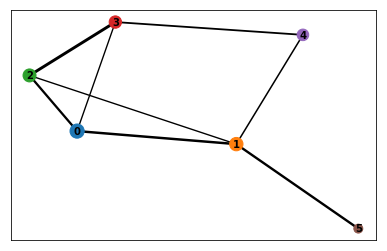

In [74]:
sc.tl.paga(myobj)
sc.pl.paga(myobj, threshold=0.15)

### Gene Activity

These chunks of code load in the hg38 coordinates of all genes (~19k) and extend the starting coordinate by 2k upstream to include promoters. 
Then, the function `gene_activity_matrix()` quantifies the accessbility of each gene. 

In [41]:
features = pd.read_csv('/project2/gca/project_organoids/metadata/hg38_gene_name_cords.txt', sep='\t', header=None)
features.columns = ['chr','start','end','gene']
features['start'] = features['start'] - 2000 # TSS + gene_body
features = features.loc[features['chr'] != 'chrM', :]
features = features.loc[features['chr'] != 'random', :]
features.drop_duplicates(subset='gene', inplace=True)

In [42]:
gene_activity = gene_activity_matrix('../scATAC-seq_Alan/RC2_Benchmark/HE021320A/outs/fragments.tsv.gz', features, myobj.obs[0].values)

 Progress: 98.38%

In [43]:
gene_activity_norm = np.log1p((gene_activity.T / gene_activity.sum(axis=1))*1e5).T

In [44]:
import magic
magic_operator = magic.MAGIC(t=5)
X_magic = magic_operator.fit_transform(gene_activity_norm)

Calculating MAGIC...
  Running MAGIC on 7673 cells and 20330 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 18.18 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.29 seconds.
    Calculating affinities...
    Calculated affinities in 7.29 seconds.
  Calculated graph and diffusion operator in 33.63 seconds.
  Running MAGIC with `solver='exact'` on 20330-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 27.60 seconds.
Calculated MAGIC in 62.74 seconds.


In [45]:
X_magic_df = pd.DataFrame(X_magic, index = gene_activity_norm.index, columns = gene_activity_norm.columns)
X_magic_df[0] = X_magic_df.index

In [46]:
myobj.obs = myobj.obs.iloc[:,[0,1,2,3]]
myobj.obs = pd.merge(myobj.obs, X_magic_df, on=0)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


### Identifying Cell Types from Activity Matrix

markers obtained from https://en.wikipedia.org/wiki/List_of_intestinal_epithelial_differentiation_genes

### Immature Markers

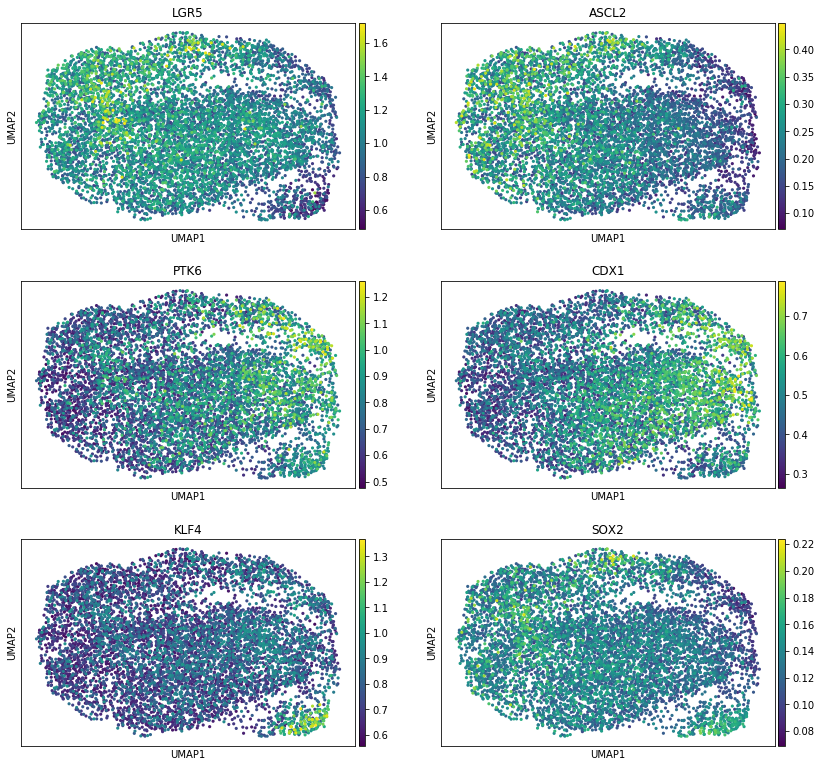

In [103]:
sc.pl.umap(myobj, color= ['LGR5','ASCL2','PTK6','CDX1','KLF4','SOX2'],size=40, ncols=2)

### Mature Cell Markers

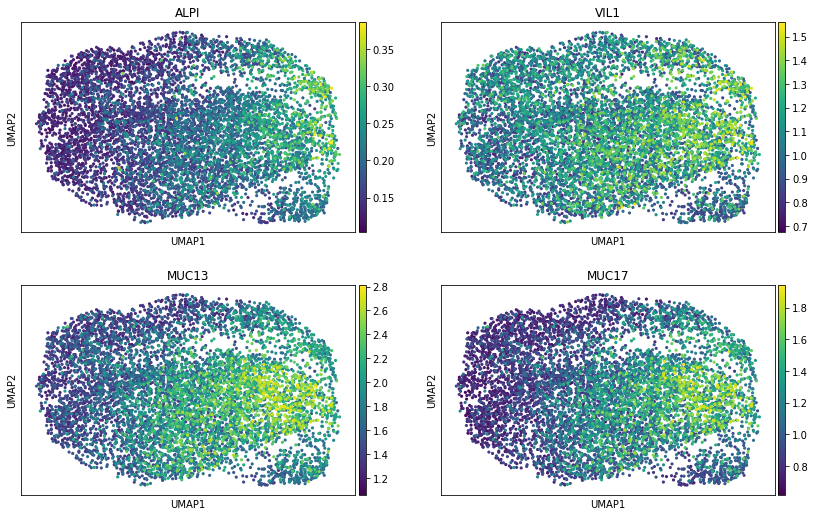

In [84]:
sc.pl.umap(myobj, color= ['ALPI','VIL1','MUC13','MUC17'],size=40, ncols=2)

In [55]:
barcodes = pd.DataFrame(index=gene_activity_norm.index.values)
genes =  pd.DataFrame(index=gene_activity_norm.columns.values)
myobj_rna = sc.AnnData(gene_activity_norm.values, var=genes, obs=barcodes)

In [57]:
myobj_rna.obs['leiden'] = myobj.obs['leiden'].values

In [61]:
sc.tl.rank_genes_groups(myobj_rna, 'leiden', method='logreg')

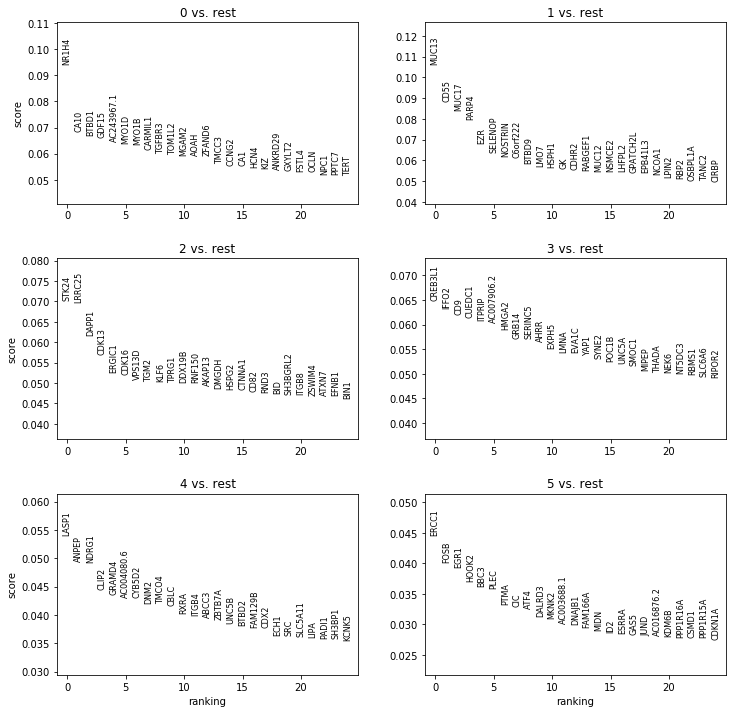

In [62]:
sc.pl.rank_genes_groups(myobj_rna, n_genes=25, ncols=2,sharey=False)

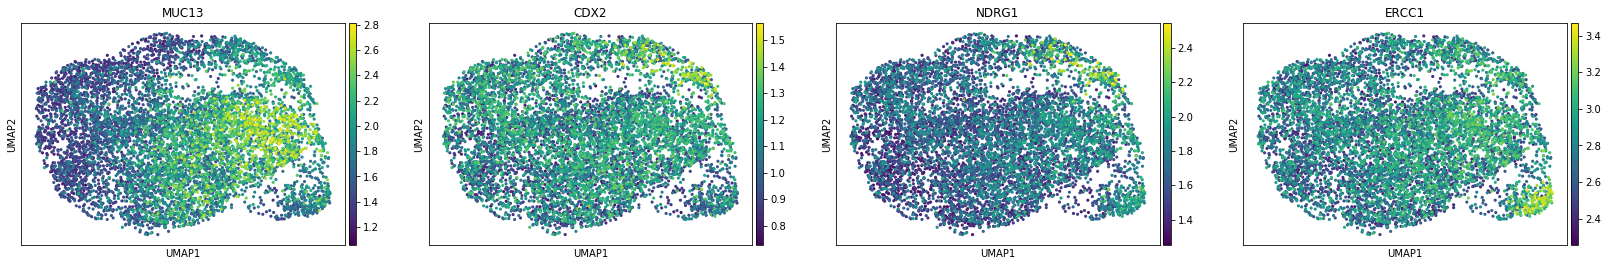

In [52]:
sc.pl.umap(myobj, color= ['MUC13','CDX2','NDRG1','ERCC1'], size=40)